# Import a Keras model into IBM Watson Machine Learning

Importing a model into Watson Machine Learning means to store a trained model in your Watson Machine Learning repository and then deploy the stored model.  This notebook demonstrates importing a Keras model.

See also: <a href="https://dataplatform.cloud.ibm.com/docs/content/analyze-data/ml-import-keras.html" target="_blank" rel="noopener noreferrer">Importing a Keras model</a>

This notebook runs on Python 3.5.


### Notebook sections

[Step 0: Build, train, and save a model](#step0)

[Step 1: Store the model in your Watson Machine Learning repository](#step1)

[Step 2: Deploy the stored modelin your Watson Machine Learning service](#step2)

## <a id="step0"></a> Step 0: Build, train, and save a model

**About the sample model**

The sample model built here classifies text messages from fictional customers into two categories:
- "social" : The message might just be social and friendly, or the message lacks enough text to perform in-depth analysis
- "problem or question" : The message describes a prob1em or asks a questions

Classifying messages this way is useful for multiple purposes:
- Automating responses (eg. respond to social messages with a generial greeting, prompting the user to type their question or problem if they have one)
- Cleaning out social message for post-hoc analysis

The data used to train the model is the "sample-customer-messages.csv" training data in the IBM Watson Studio community: <a href="https://dataplatform.cloud.ibm.com/exchange/public/entry/view/015ddef6a868441188268a123404f744" target="_blank" rel="noopener noreferrer">Customer messages sample data</a>.

### Get and prepare training data

In [ ]:
!pip install wget # Needed to download sample training data

In [40]:
# Download sample training data to the notebook working directory
import wget
training_data_url = 'https://dataplatform.cloud.ibm.com/data/exchange-api/v1/entries/015ddef6a868441188268a123404f744/data?accessKey=c8d0403d844a82df9ecd264df02f2b07'
filename = wget.download( training_data_url )
print( filename )

sample-customer-messages.csv


In [73]:
# Read sample data into Pandas DataFrame
import pandas as pd
df = pd.read_csv( filename, names=[ "message", "class_name" ] )
df[6:9]

,message,class_name
6,Greetings :),hi
7,hai how can i do analyze with csv file is ther...,question
8,Having issues setup WML service,problem


In [74]:
# Split the data into training and test sets
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
from sklearn.model_selection import train_test_split
train, test = train_test_split( df, test_size = 0.1 )
test

,message,class_name
96,Uploading data from object storage to rstudio ...,problem
99,When I try to add a model to any project I get...,problem
92,Im trying to create a python notebook and keep...,problem
34,hi,hi
55,Hi I want to know how to make connection to da...,question
65,Hi My problem is an error when I want to creat...,problem
3,good morning,hi
12,hello,hi
33,hi,hi
45,Hi how do you add a folder of files to a project?,question


In [75]:
# Convert words to numbers
# https://keras.io/preprocessing/text/#tokenizer
from keras.preprocessing.text import Tokenizer
t = Tokenizer()
t.fit_on_texts( train["message"] )
X_train = t.texts_to_sequences( train["message"] )
X_test  = t.texts_to_sequences( test["message"] )
X_test[0:4]

[[145, 15, 23, 78, 79, 2, 158, 42, 22],
 [24, 1, 108, 2, 161, 4, 31, 2, 47, 33, 1, 58, 42, 22],
 [16, 21, 2, 18, 4, 152, 9, 38, 71, 40, 42, 22],
 [3]]

In [76]:
# Pad the shorter entries
# https://keras.io/preprocessing/sequence/#pad_sequences
from keras.preprocessing.sequence import pad_sequences
max_len = max( len(x) for x in X_train )
X_train = pad_sequences( X_train, padding='post', maxlen=max_len )
X_test  = pad_sequences( X_test,  padding='post', maxlen=max_len )
X_test[0]

array([145,  15,  23,  78,  79,   2, 158,  42,  22,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0], dtype=int32)

In [77]:
# Convert the labels to binary labels
import scipy
import numpy as np
y_train = np.array( [ [ 1, 0 ] if class_name == "hi" else [ 0, 1 ] for class_name in train[ "class_name" ] ] )
y_test  = np.array( [ [ 1, 0 ] if class_name == "hi" else [ 0, 1 ] for class_name in test[ "class_name" ] ] )
y_test

array([[0, 1],
       [0, 1],
       [0, 1],
       [1, 0],
       [0, 1],
       [0, 1],
       [1, 0],
       [1, 0],
       [1, 0],
       [0, 1]])

### Build a neural network

In [78]:
# Create a simple sequential model
# https://keras.io/models/sequential

from keras.models import Sequential
from keras import layers

vocab_size    = len( t.word_counts ) + 1
embedding_dim = 50
num_classes   = 2

model = Sequential()
model.add( layers.Embedding( input_dim    = vocab_size,        # https://keras.io/layers/embeddings
                             output_dim   = embedding_dim, 
                             input_length = max_len,
                             trainable    = True ) )
model.add( layers.Flatten() )                                  # https://keras.io/layers/core/#flatten
model.add( layers.Dense( num_classes, activation='sigmoid' ) ) # https://keras.io/layers/core/#dense
model.add( layers.Activation( "softmax" ) )                    # https://en.wikipedia.org/wiki/Softmax_function

model.compile( optimizer = "adam",                # https://www.dlology.com/blog/quick-notes-on-how-to-choose-optimizer-in-keras
               loss      = "binary_crossentropy", # https://www.dlology.com/blog/how-to-choose-last-layer-activation-and-loss-function
               metrics   = [ "accuracy" ] )

### Train and evaluate model

In [79]:
history = model.fit( X_train, y_train,
                     batch_size = 10,
                     epochs     = 15,
                     verbose    = False,
                     validation_split = 0.1 )

In [80]:
import matplotlib.pyplot as plt
plt.style.use( "seaborn-white" )

def plot_progress( history ):
    train_acc  = history['acc']
    val_acc    = history['val_acc']
    train_loss = history['loss']
    val_loss   = history['val_loss']
    x = range( 1, len( train_acc ) + 1 )

    plt.figure( figsize=( 12, 4 ) )
    plt.subplot( 1, 2, 1)
    plt.title(  "Accuracy", fontsize = 18)
    plt.plot( x, train_acc, label = "Training" )
    plt.plot( x, val_acc,   label = "Validation" )
    plt.legend( loc="upper left" )
    plt.subplot( 1, 2, 2 )
    plt.title(  "Loss", fontsize = 18 )
    plt.plot( x, train_loss, label = "Training" )
    plt.plot( x, val_loss,   label = "Validation" )
    plt.legend()

Training accuracy: 100.0%
Testing accuracy:  100.0%


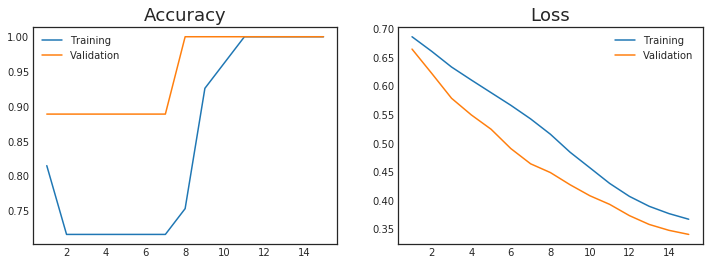

In [81]:
train_score = model.evaluate( X_train, y_train, verbose = False )
test_score  = model.evaluate( X_test, y_test, verbose = False)
print( "Training accuracy: " + str( round( 100 * train_score[1] ) ) + "%" )
print( "Testing accuracy:  " + str( round( 100 * test_score[1] ) ) + "%" )
plot_progress( history.history )

In [82]:
test

,message,class_name
96,Uploading data from object storage to rstudio ...,problem
99,When I try to add a model to any project I get...,problem
92,Im trying to create a python notebook and keep...,problem
34,hi,hi
55,Hi I want to know how to make connection to da...,question
65,Hi My problem is an error when I want to creat...,problem
3,good morning,hi
12,hello,hi
33,hi,hi
45,Hi how do you add a folder of files to a project?,question


In [83]:
test_results = model.predict_classes( X_test )
print( test_results )

[1 1 1 0 1 1 0 0 0 1]


### Save the model in a .tgz file

In [84]:
# https://keras.io/getting-started/faq/#how-can-i-save-a-keras-model
model.save( "message-classification-model.h5" )

In [85]:
!tar -zcvf message-classification-model.tgz message-classification-model.h5

message-classification-model.h5


In [86]:
!ls -l

total 428
-rw-r----- 1 dsxuser dsxuser 236960 Mar  5 22:21 message-classification-model.h5
-rw-r----- 1 dsxuser dsxuser 192448 Mar  5 22:21 message-classification-model.tgz
-rw-r----- 1 dsxuser dsxuser   5781 Mar  5 21:51 sample-customer-messages.csv


## <a id="step1"></a> Step 1: Store the model in your Watson Machine Learning repository

This section of the notebook demonstrates calling the <a href="https://wml-api-pyclient.mybluemix.net/index.html?highlight=store_model#client.Repository.store_model" target="_blank" rel="noopener noreferrer">deployments.create</a> function

Paste your Watson Machine Learning credentials in the following cell.

See: <a href="https://dataplatform.cloud.ibm.com/docs/content/analyze-data/ml-get-wml-credentials.html" target="_blank" rel="noopener noreferrer">Looking up credentials</a>

In [ ]:
# Create a Watson Machine Learning client instance
from watson_machine_learning_client import WatsonMachineLearningAPIClient
wml_credentials = {
    "instance_id" : "",
    "password"    : "",
    "url"         : "",
    "username"    : ""
}
client = WatsonMachineLearningAPIClient( wml_credentials )

In [88]:
metadata = {
    client.repository.ModelMetaNames.NAME: "keras model",
    client.repository.ModelMetaNames.FRAMEWORK_NAME: "tensorflow",
    client.repository.ModelMetaNames.FRAMEWORK_VERSION: "1.5"
}
model_details = client.repository.store_model( model="message-classification-model.tgz", meta_props=metadata )

## <a id="step2"></a> Step 2: Deploy the stored the model in your Watson Machine Learning service

This section of the notebook demonstrates calling the <a href="https://wml-api-pyclient.mybluemix.net/index.html?highlight=deploy#client.Deployments.create" target="_blank" rel="noopener noreferrer">deployments.create</a> function

In [90]:
# Deploy the stored model as an online web service deployment
model_id = model_details["metadata"]["guid"]
deployment_details = client.deployments.create( artifact_uid=model_id, name="Keras deployment" )



#######################################################################################

Synchronous deployment creation for uid: '62e38c60-deff-40c1-a826-22da5be507dd' started

#######################################################################################


INITIALIZING
DEPLOY_IN_PROGRESS
DEPLOY_SUCCESS


------------------------------------------------------------------------------------------------
Successfully finished deployment creation, deployment_uid='93ccbba8-fc19-4918-92df-cfc66476827a'
------------------------------------------------------------------------------------------------




In [93]:
# Test the deployment
model_endpoint_url = client.deployments.get_scoring_url( deployment_details )
payload = { "values" : X_test.tolist() }
client.deployments.score( model_endpoint_url, payload )

{'fields': ['prediction', 'prediction_classes', 'probability'],
 'values': [[[0.3128162622451782, 0.6871837377548218],
   1,
   [0.3128162622451782, 0.6871837377548218]],
  [[0.2732200622558594, 0.7267799377441406],
   1,
   [0.2732200622558594, 0.7267799377441406]],
  [[0.2782357931137085, 0.7217642068862915],
   1,
   [0.2782357931137085, 0.7217642068862915]],
  [[0.6962097883224487, 0.30379027128219604],
   0,
   [0.6962097883224487, 0.30379027128219604]],
  [[0.28166523575782776, 0.7183347940444946],
   1,
   [0.28166523575782776, 0.7183347940444946]],
  [[0.2796854078769684, 0.720314621925354],
   1,
   [0.2796854078769684, 0.720314621925354]],
  [[0.6883417367935181, 0.3116582930088043],
   0,
   [0.6883417367935181, 0.3116582930088043]],
  [[0.6964345574378967, 0.30356544256210327],
   0,
   [0.6964345574378967, 0.30356544256210327]],
  [[0.6962097883224487, 0.30379021167755127],
   0,
   [0.6962097883224487, 0.30379021167755127]],
  [[0.2826327383518219, 0.7173673510551453],
  

## Summary
In this notebook, you imported a scikit-learn Pipeline into Watson Machine Learning using the Watson Machine Learning Python client.

### <a id="authors"></a>Authors

**Sarah Packowski** is a member of the IBM Watson Studio Content Design team in Canada.


<hr>
Copyright &copy; IBM Corp. 2019. This notebook and its source code are released under the terms of the MIT License.

<div style="background:#F5F7FA; height:110px; padding: 2em; font-size:14px;">
<span style="font-size:18px;color:#152935;">Love this notebook? </span>
<span style="font-size:15px;color:#152935;float:right;margin-right:40px;">Don't have an account yet?</span><br>
<span style="color:#5A6872;">Share it with your colleagues and help them discover the power of Watson Studio!</span>
<span style="border: 1px solid #3d70b2;padding:8px;float:right;margin-right:40px; color:#3d70b2;"><a href="https://ibm.co/wsnotebooks" target="_blank" style="color: #3d70b2;text-decoration: none;">Sign Up</a></span><br>
</div>